In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.cluster import KMeans

In [59]:
df1 = pd.read_csv('data/trips_2018_cleaned.csv',index_col=0)

In [60]:
df1.head()

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week
tripduration,,,,,,,,,,,,,,,,,,
970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1
723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1
496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1
306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1
306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1


# Task 1

In [66]:
all_stations = pd.concat([
    df1[['start_station_id', 'start_station_latitude', 'start_station_longitude']],
    df1[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_id': 'start_station_id',
                 'end_station_latitude': 'start_station_latitude',
                 'end_station_longitude': 'start_station_longitude'}
    )
]).drop_duplicates().dropna()

print(f"Total unique stations: {len(all_stations)}")

Total unique stations: 845


Coordinate range:
  Lat: 4511766 to 4530398 meters
  Lon: -6297109 to -6282158 meters

Testing different K values...
K=1: Inertia=2.09e+10
K=4: Inertia=4.29e+09
K=7: Inertia=2.28e+09
K=10: Inertia=1.47e+09
K=13: Inertia=1.09e+09
K=16: Inertia=8.64e+08
K=19: Inertia=7.23e+08
K=22: Inertia=6.22e+08
K=25: Inertia=5.45e+08
K=28: Inertia=4.80e+08
K=31: Inertia=4.20e+08
K=34: Inertia=3.81e+08
K=37: Inertia=3.46e+08
K=40: Inertia=3.15e+08
K=43: Inertia=2.91e+08
K=46: Inertia=2.69e+08
K=49: Inertia=2.53e+08


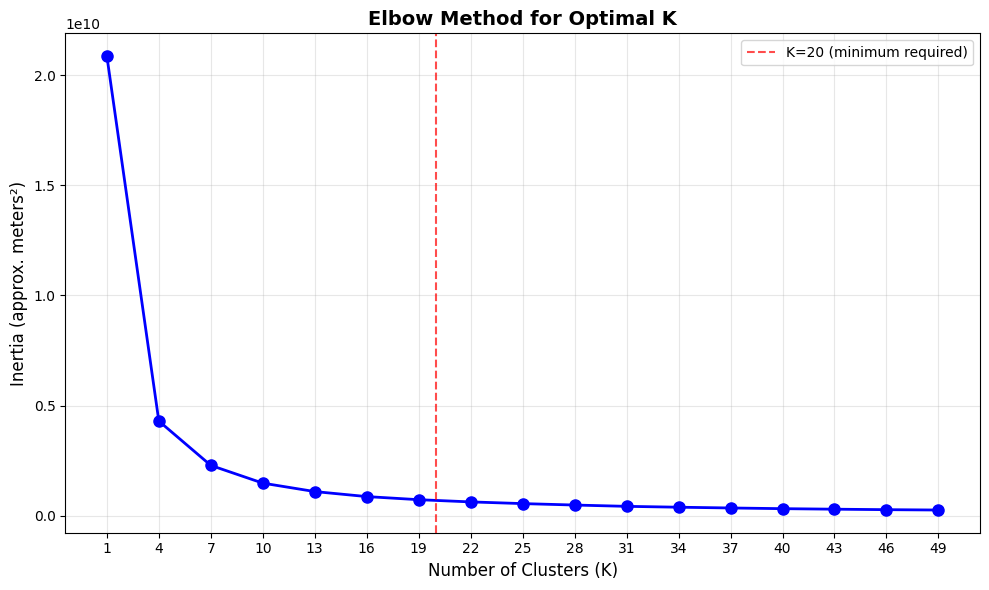

In [70]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# CONVERT LAT/LON TO APPROXIMATE METERS

lat = all_stations['start_station_latitude'].values
lon = all_stations['start_station_longitude'].values

# Approximate conversion for New York area (40.7°N)
# 1 degree latitude ≈ 111,000 meters
# 1 degree longitude ≈ 85,000 meters (at 40°N latitude)

lat_meters = lat * 111000  # meters
lon_meters = lon * 85000   # meters (adjusted for NYC latitude)

X_meters = np.column_stack([lat_meters, lon_meters])

print(f"Coordinate range:")
print(f"  Lat: {lat_meters.min():.0f} to {lat_meters.max():.0f} meters")
print(f"  Lon: {lon_meters.min():.0f} to {lon_meters.max():.0f} meters")

# ELBOW METHOD TO FIND OPTIMAL K

X = X_meters

k_values = range(1, 51, 3)
inertias = []

print("\nTesting different K values...")
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=67, n_init=20)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
    print(f"K={k}: Inertia={kmeans.inertia_:.2e}")

# ============================================================================
# PLOT ELBOW CURVE
# ============================================================================

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (approx. meters²)', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

plt.axvline(x=20, color='red', linestyle='--', alpha=0.7, label='K=20 (minimum required)')
plt.legend()

plt.tight_layout()
plt.savefig('elbow_plot_meters.png', dpi=300, bbox_inches='tight')
plt.show()


In [71]:
kmeans = KMeans(n_clusters=20, random_state=67, n_init=20)
all_stations['cluster'] = kmeans.fit_predict(X_meters)

In [72]:
station_to_cluster = dict(zip(
    all_stations['start_station_id'], 
    all_stations['cluster']
))

# Add to df1
df1['start_cluster'] = df1['start_station_id'].map(station_to_cluster)
df1['end_cluster'] = df1['end_station_id'].map(station_to_cluster)

# Verify
print(f"\nMissing start clusters: {df1['start_cluster'].isna().sum()}")
print(f"Missing end clusters: {df1['end_cluster'].isna().sum()}")

df1.head()


Missing start clusters: 0
Missing end clusters: 0


,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,calculated_duration,date,hour,day_of_week,month,week,start_cluster,end_cluster
tripduration,,,,,,,,,,,,,,,,,,,,
970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767272,-73.993929,505,40.749013,-73.988484,31956,Subscriber,1992,1,970.752,2018-01-01,13,Monday,1,1,12,16
723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767272,-73.993929,3255,40.750585,-73.994685,32536,Subscriber,1969,1,723.159,2018-01-01,15,Monday,1,1,12,16
496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767272,-73.993929,525,40.755942,-74.002116,16069,Subscriber,1956,1,496.835,2018-01-01,15,Monday,1,1,12,12
306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767272,-73.993929,447,40.763707,-73.985162,31781,Subscriber,1974,1,306.819,2018-01-01,15,Monday,1,1,12,12
306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767272,-73.993929,3356,40.774667,-73.984706,30319,Subscriber,1992,1,306.074,2018-01-01,18,Monday,1,1,12,1


# Task 2

In [74]:
# Selecting top 3 clusters by total demand for analysis
cluster_demand = df1.groupby('start_cluster').size().sort_values(ascending=False)
selected_clusters = cluster_demand.head(3).index.tolist()

print(f"SELECTED CLUSTERS FOR PREDICTION: {selected_clusters}")


for cluster_id in selected_clusters:
    total_pickups = cluster_demand[cluster_id]
    num_stations = df1[df1['start_cluster'] == cluster_id]['start_station_id'].nunique()
    print(f"\nCluster {cluster_id}:")
    print(f"  - Total pickups: {total_pickups:,}")
    print(f"  - Number of stations: {num_stations}")

SELECTED CLUSTERS FOR PREDICTION: [16, 0, 18]

Cluster 16:
  - Total pickups: 2,546,906
  - Number of stations: 49

Cluster 0:
  - Total pickups: 2,381,714
  - Number of stations: 51

Cluster 18:
  - Total pickups: 1,909,563
  - Number of stations: 58


## Feature Helper Functions

In [53]:
# Feature Engineering Functions
import pandas as pd
import numpy as np

def aggregate_hourly_demand(df, cluster_id, target='pickups'):
    if target == 'pickups':
        cluster_trips = df[df['start_cluster'] == cluster_id].copy()
    else:
        cluster_trips = df[df['end_cluster'] == cluster_id].copy()
    
    cluster_trips['timestamp'] = pd.to_datetime(cluster_trips['date']) + pd.to_timedelta(cluster_trips['hour'], unit='h')
    hourly_counts = cluster_trips.groupby('timestamp').size().reset_index(name=target)
    hourly_counts = hourly_counts.set_index('timestamp').sort_index()
    
    full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
    hourly_counts = hourly_counts.reindex(full_range, fill_value=0)
    
    return hourly_counts

def add_time_features(hourly_data):
    df = hourly_data.copy()
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_rush_hour'] = df['hour_of_day'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    return df

def add_lag_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['lag_1h'] = df[target_col].shift(1)
    df['lag_24h'] = df[target_col].shift(24)
    df['lag_168h'] = df[target_col].shift(168)
    return df

def add_rolling_features(hourly_data, target_col):
    df = hourly_data.copy()
    df['avg_last_3h'] = df[target_col].shift(1).rolling(window=3).mean()
    df['avg_last_24h'] = df[target_col].shift(1).rolling(window=24).mean()
    df['max_last_24h'] = df[target_col].shift(1).rolling(window=24).max()
    return df

def add_cyclical_features(hourly_data, target_col, train_cutoff='2018-10-31 23:59:59'):
    """
    Calculate only on training data.
    """
    df = hourly_data.copy()
    
    # Only use training data to calculate statistics
    train_data = df[df.index <= train_cutoff]
    
    # Hour of day stats
    hour_stats = train_data.groupby('hour_of_day')[target_col].mean()
    df['typical_hour_mean'] = df['hour_of_day'].map(hour_stats)
    
    # Day of week stats
    dow_stats = train_data.groupby('day_of_week')[target_col].mean()
    df['typical_dow_mean'] = df['day_of_week'].map(dow_stats)
    
    return df



## Complete Feature Function

In [54]:
def build_all_features(df, cluster_id, target='pickups'):
    hourly_data = aggregate_hourly_demand(df, cluster_id, target)
    hourly_data = add_time_features(hourly_data)
    hourly_data = add_lag_features(hourly_data, target)
    hourly_data = add_rolling_features(hourly_data, target)
    hourly_data = add_cyclical_features(hourly_data, target)
    hourly_data = hourly_data.dropna()
    return hourly_data

In [55]:
# Build features for all clusters
all_cluster_features = {}

for cluster_id in selected_clusters:
    pickups_features = build_all_features(df1, cluster_id, target='pickups')
    dropoffs_features = build_all_features(df1, cluster_id, target='dropoffs')
    
    all_cluster_features[cluster_id] = {
        'pickups': pickups_features,
        'dropoffs': dropoffs_features
    }
    
    print(f"Cluster {cluster_id}: {pickups_features.shape[0]} samples, {pickups_features.shape[1]} features")

/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_82499/176504382.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_82499/176504382.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 2: 8592 samples, 14 features


/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_82499/176504382.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')
/var/folders/_3/spv5x2714tbb6xsc2xwzh3hr0000gn/T/ipykernel_82499/176504382.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=hourly_counts.index.min(), end=hourly_counts.index.max(), freq='H')


Cluster 11: 8592 samples, 14 features


# Train / Test splits

In [40]:
# Train/test split
def split_time_series_data(ts_features, cutoff_date='2018-10-31 23:59:59', target='pickups'):
    feature_columns = [col for col in ts_features.columns if col not in [target]]
    
    train_mask = ts_features.index <= cutoff_date
    test_mask = ts_features.index > cutoff_date
    
    X_train = ts_features.loc[train_mask, feature_columns]
    y_train = ts_features.loc[train_mask, target]
    X_test = ts_features.loc[test_mask, feature_columns]
    y_test = ts_features.loc[test_mask, target]
    
    return X_train, X_test, y_train, y_test

# Models 

In [ ]:
# Evaluation metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def print_stats(y_test, y_preds, title="Model"):
    print(f"{title}:")
    print(f"\tR² = {r2_score(y_test, y_preds):.4f}")
    print(f"\tRMSE = {np.sqrt(mean_squared_error(y_test, y_preds)):.2f}")
    print(f"\tMAE = {mean_absolute_error(y_test, y_preds):.2f}")

In [56]:
# Train models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

results = []

for cluster_id in selected_clusters:
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    
    for target in ['pickups', 'dropoffs']:
        print(f"\n{target.upper()}:")
        
        # Get features
        ts_data = all_cluster_features[cluster_id][target]
        
        # Split data
        X_train, X_test, y_train, y_test = split_time_series_data(ts_data, target=target)
        
        # Baseline: Last week
        baseline_pred = ts_data.loc[y_test.index, 'lag_168h'].values
        print_stats(y_test, baseline_pred, "Baseline (Last Week)")
        
        # Ridge Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_train_scaled, y_train)
        ridge_pred = np.maximum(ridge.predict(X_test_scaled), 0)
        print_stats(y_test, ridge_pred, "Ridge")
        
        # Gradient Boosting
        gb = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
        gb.fit(X_train, y_train)
        gb_pred = np.maximum(gb.predict(X_test), 0)
        print_stats(y_test, gb_pred, "Gradient Boosting")
        
        results.append({
            'cluster': cluster_id,
            'target': target,
            'baseline_rmse': np.sqrt(mean_squared_error(y_test, baseline_pred)),
            'ridge_rmse': np.sqrt(mean_squared_error(y_test, ridge_pred)),
            'gb_rmse': np.sqrt(mean_squared_error(y_test, gb_pred))
        })


CLUSTER 2

PICKUPS:
Baseline (Last Week):
	R² = 0.4300
	RMSE = 150.20
	MAE = 88.77
Ridge:
	R² = 0.8480
	RMSE = 77.55
	MAE = 51.95
Gradient Boosting:
	R² = 0.9487
	RMSE = 45.05
	MAE = 28.38

DROPOFFS:
Baseline (Last Week):
	R² = 0.4694
	RMSE = 154.16
	MAE = 89.15
Ridge:
	R² = 0.8398
	RMSE = 84.72
	MAE = 56.11
Gradient Boosting:
	R² = 0.9521
	RMSE = 46.31
	MAE = 28.91

CLUSTER 11

PICKUPS:
Baseline (Last Week):
	R² = 0.5226
	RMSE = 102.14
	MAE = 59.58
Ridge:
	R² = 0.8020
	RMSE = 65.79
	MAE = 43.62
Gradient Boosting:
	R² = 0.9473
	RMSE = 33.92
	MAE = 22.40

DROPOFFS:
Baseline (Last Week):
	R² = 0.4687
	RMSE = 105.93
	MAE = 60.46
Ridge:
	R² = 0.8490
	RMSE = 56.47
	MAE = 36.78
Gradient Boosting:
	R² = 0.9165
	RMSE = 42.00
	MAE = 24.73


In [57]:
# Results summary
results_df = pd.DataFrame(results)
print("\n", results_df)


    cluster    target  baseline_rmse  ridge_rmse    gb_rmse
0        2   pickups     150.197070   77.551276  45.046393
1        2  dropoffs     154.156211   84.716901  46.306901
2       11   pickups     102.140955   65.790446  33.924050
3       11  dropoffs     105.929860   56.474482  41.999065
